In [1]:
!pip install ucimlrepo

In [2]:
config = {
    "create_sample_dataset": False, #True: creates a small sample of the dataset. False: doesn't.
    "fraction": 1/1000, #Chooses the required fraction to make the sample.
    "null_threshold": 0.1, #Useful for dropping features which have null values more than the threshold.
    "imbalance_threshold": 0.8, #an indicator that is used to see whether the labels are imbalanced.
    
    "max_depth": 14, #(stopping criteria)
    "min_samples_split": 5, #(stopping criteria)
    "min_impurity_decrease": 0.01, #(stopping criteria)
    "criterion": "entropy", #(expansion criteria) ["gini", "entropy"]
    
    "do_cross_validation": False
}

In [3]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
from itertools import chain, combinations
from collections import Counter
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import classification_report
from itertools import combinations
import random
# Fetch the dataset
secondary_mushroom = fetch_ucirepo(id=848)
X = secondary_mushroom.data.features
y = secondary_mushroom.data.targets["class"].apply(lambda x: 1 if x == "p" else 0)
data = pd.concat([X, y], axis=1)
print(data.info())

# Calculate the percentage of null values for each feature
missing_ratios = data.isnull().mean()

# Identify features with more than the threshold of null values
features_to_drop = missing_ratios[missing_ratios > config["null_threshold"]].index

# Display features to drop
print(f"\nFeatures with more than {config['null_threshold'] * 100}% null values:")
print(features_to_drop)

# Drop those features
data = data.drop(columns=features_to_drop)

# Remove rows with any null values
data = data.dropna()
data.reset_index(drop=True, inplace=True)


print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cap-diameter          61069 non-null  float64
 1   cap-shape             61069 non-null  object 
 2   cap-surface           46949 non-null  object 
 3   cap-color             61069 non-null  object 
 4   does-bruise-or-bleed  61069 non-null  object 
 5   gill-attachment       51185 non-null  object 
 6   gill-spacing          36006 non-null  object 
 7   gill-color            61069 non-null  object 
 8   stem-height           61069 non-null  float64
 9   stem-width            61069 non-null  float64
 10  stem-root             9531 non-null   object 
 11  stem-surface          22945 non-null  object 
 12  stem-color            61069 non-null  object 
 13  veil-type             3177 non-null   object 
 14  veil-color            7413 non-null   object 
 15  has-ring           

data.shape (58598, 13)
Class 0: 25769 samples (43.98%)
Class 1: 32829 samples (56.02%)
The dataset is not significantly imbalanced.


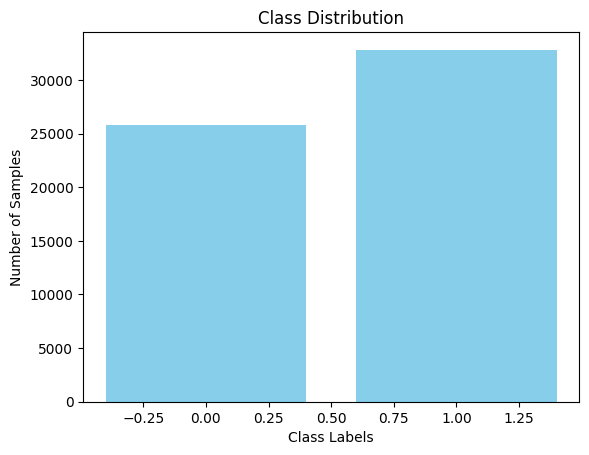

In [4]:
if config["create_sample_dataset"] == True:
    data = data.sample(frac=config["fraction"], random_state=42)
    data.reset_index(drop=True, inplace=True)

print("data.shape", data.shape)

# Split back into X and y
X = data.drop(columns="class")
y = data[["class"]]


# Check the class distribution
unique_classes, class_counts = np.unique(y, return_counts=True)

# Display class distribution
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count} samples ({count / len(y) * 100:.2f}%)")

# Calculate imbalance ratio
if max(class_counts) / len(y) >= config["imbalance_threshold"]:
    print(f"The dataset is imbalanced. The largest class makes up {imbalance_ratio * 100:.2f}% of the dataset.")
else:
    print("The dataset is not significantly imbalanced.")

# Visualize class distribution
plt.bar(unique_classes, class_counts, color='skyblue')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.savefig('class_distribution.png')
plt.savefig('class_distribution.pdf')  
plt.show()

In [5]:
#Showing the number of unique categories for each categorical feature
for col in data.columns:
    if not np.issubdtype(type(data[col].iloc[0]), np.float64):
        unique_values = data[col].nunique()
        print(f"Feature '{col}' has {unique_values} unique categories.", data[col].unique())


Feature 'cap-shape' has 7 unique categories. ['x' 'f' 'p' 'b' 'c' 's' 'o']
Feature 'cap-color' has 12 unique categories. ['o' 'e' 'n' 'g' 'r' 'w' 'y' 'p' 'u' 'b' 'l' 'k']
Feature 'does-bruise-or-bleed' has 2 unique categories. ['f' 't']
Feature 'gill-color' has 12 unique categories. ['w' 'n' 'p' 'u' 'b' 'g' 'y' 'r' 'e' 'o' 'k' 'f']
Feature 'stem-color' has 13 unique categories. ['w' 'y' 'n' 'u' 'b' 'l' 'r' 'p' 'e' 'k' 'g' 'o' 'f']
Feature 'has-ring' has 2 unique categories. ['t' 'f']
Feature 'ring-type' has 8 unique categories. ['g' 'p' 'e' 'l' 'f' 'm' 'r' 'z']
Feature 'habitat' has 8 unique categories. ['d' 'm' 'g' 'h' 'l' 'p' 'w' 'u']
Feature 'season' has 4 unique categories. ['w' 'u' 'a' 's']
Feature 'class' has 2 unique categories. [1 0]


In [6]:
data.head(3)

,cap-diameter,cap-shape,cap-color,does-bruise-or-bleed,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season,class
0,15.26,x,o,f,w,16.95,17.09,w,t,g,d,w,1
1,16.60,x,o,f,w,17.99,18.19,w,t,g,d,u,1
2,14.07,x,o,f,w,17.80,17.74,w,t,g,d,w,1


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42)

In [8]:
# Node class
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None, categories=None):
        self.feature = feature
        self.threshold = threshold  # Numerical features
        self.categories = categories  # Categorical features
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None


# Decision Tree class
class DecisionTree:
    def __init__(self, max_depth=config["max_depth"], min_samples_split=config["min_samples_split"], min_impurity_decrease=config["min_impurity_decrease"], criterion=config["criterion"]):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_impurity_decrease = min_impurity_decrease
        self.criterion = criterion
        self.root = None

    def fit(self, X, y):
        self.root = self._build_tree(X, y, depth=0)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _build_tree(self, X, y, depth):
        n_samples, n_features = X.shape
        num_labels = len(np.unique(y))
        # print("depth: ", depth)
        # Stopping criteria
        if depth >= self.max_depth or num_labels == 1 or n_samples < self.min_samples_split:
            return Node(value=self._most_common_label(y))

        # Find the best split
        best_split = self._best_split(X, y)
        if not best_split:  # No valid split found
            return Node(value=self._most_common_label(y))

        feature, threshold, categories, X_left, X_right, y_left, y_right, impurity_decrease = best_split

        # Check impurity decrease criterion
        if impurity_decrease < self.min_impurity_decrease:
            return Node(value=self._most_common_label(y))

        # Recursively build left and right subtrees
        # print("creating left child in depth ", depth)
        left_child = self._build_tree(X_left, y_left, depth + 1)
        # print("finished left child in depth ", depth)
        # print("creating right child in depth ", depth)
        right_child = self._build_tree(X_right, y_right, depth + 1)
        # print("finished right child in depth ", depth)
        return Node(feature, threshold, left_child, right_child, categories=categories)

    def _best_split(self, X, y):
        # print("inside best_split")
        n_samples, n_features = X.shape
        best_score = float("inf")
        best_split = None
        current_impurity = self._calculate_criterion(y)
    
        for feature_idx in range(n_features):
            feature_values = X[:, feature_idx]
    
            # Check for numerical or categorical feature
            if np.issubdtype(type(feature_values[0]), np.float_):
                # print("numeric feature")
                thresholds = np.unique(feature_values)
                for threshold in thresholds:
                    X_left, X_right, y_left, y_right = self._split_numeric(X, y, feature_idx, threshold)
                    if len(y_left) == 0 or len(y_right) == 0:
                        continue
                    score = self._weighted_impurity(y_left, y_right)
                    impurity_decrease = current_impurity - score
                    if score < best_score:
                        best_score = score
                        best_split = (feature_idx, threshold, None, X_left, X_right, y_left, y_right, impurity_decrease)
            else:
                # Handle categorical features
                # print("categorical feature")
                categories = np.unique(feature_values)
                for subset in self._all_subsets(categories):
                    X_left, X_right, y_left, y_right = self._split_categorical(X, y, feature_idx, subset)
                    if len(y_left) == 0 or len(y_right) == 0:
                        continue
                    score = self._weighted_impurity(y_left, y_right)
                    impurity_decrease = current_impurity - score
                    if score < best_score:
                        best_score = score
                        best_split = (feature_idx, None, subset, X_left, X_right, y_left, y_right, impurity_decrease)
        # print("new best split ...")
        return best_split

    def _split_numeric(self, X, y, feature_idx, threshold):
        left_idx = X[:, feature_idx] <= threshold
        right_idx = X[:, feature_idx] > threshold
        return X[left_idx], X[right_idx], y[left_idx], y[right_idx]

    def _split_categorical(self, X, y, feature_idx, categories):
        left_idx = np.isin(X[:, feature_idx], categories)
        right_idx = ~left_idx
        # print("feature idx:", feature_idx , "X[left_idx]", X[left_idx, feature_idx], "___" ,"X[right_idx]", X[right_idx, feature_idx])
        return X[left_idx], X[right_idx], y[left_idx], y[right_idx]

    def _all_subsets(self, categories):
        # Define subset size range
        n_categories = len(categories)
        min_size = max(1, n_categories // 2)  
        max_size = max(1, int(n_categories * 0.8))  
        subsets = []
        random.shuffle(categories)
    
        # Generate subsets iteratively
        for subset_size in range(min_size, max_size + 1):
            for subset in combinations(categories, subset_size):
                subsets.append(subset)
                if len(subsets) == 5:
                    return subsets
        return subsets

    def _weighted_impurity(self, y_left, y_right):
        n = len(y_left) + len(y_right)
        p_left, p_right = len(y_left) / n, len(y_right) / n
        return p_left * self._calculate_criterion(y_left) + p_right * self._calculate_criterion(y_right)

    def _calculate_criterion(self, y):
        if self.criterion == "gini":
            return self._gini(y)
        elif self.criterion == "entropy":
            return self._entropy(y)

    def _gini(self, y):
        class_counts = Counter(y.flatten() if isinstance(y, np.ndarray) else y)
        impurity = 1
        total_samples = len(y)
        for cls in class_counts:
            prob_of_cls = class_counts[cls] / total_samples
            impurity -= prob_of_cls ** 2
        return impurity

    def _entropy(self, y):
        class_counts = Counter(y.flatten() if isinstance(y, np.ndarray) else y)
        total_samples = len(y)
        entropy = 0
        for cls in class_counts:
            prob_of_cls = class_counts[cls] / total_samples
            entropy -= prob_of_cls * np.log2(prob_of_cls + 1e-9)  # Adding a small value to prevent log(0)
        return entropy
    
    def _most_common_label(self, y):
        if isinstance(y, np.ndarray):
            y = y.flatten()  
        elif isinstance(y, pd.Series): 
            y = y.values.flatten()  
        elif isinstance(y, pd.DataFrame):
            y = y.squeeze()  
        return Counter(y).most_common(1)[0][0]

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value
        if node.categories is not None:  # Categorical feature
            if x[node.feature] in node.categories:
                return self._traverse_tree(x, node.left)
            else:
                return self._traverse_tree(x, node.right)
        else:  # Numerical feature
            if x[node.feature] <= node.threshold:
                return self._traverse_tree(x, node.left)
            else:
                return self._traverse_tree(x, node.right)

In [9]:
def hyperparameter_tuning(X, y):

    params = {
        "criterion": ["gini", "entropy"],
        "max_depth": range(8, 20),
        "min_samples_split": [5],
        "min_impurity_decrease": [0.01]
    }

    kf = KFold(n_splits=2, shuffle=True, random_state=42)
    best_score = 0
    results = []

    for criterion in params["criterion"]:
        print("criterion: ", criterion)
        for max_depth in params["max_depth"]:
            print("\tmax_depth", max_depth)
            for min_samples_split in params["min_samples_split"]:
                print("\t\tmin_samples_split", min_samples_split)
                for min_impurity_decrease in params["min_impurity_decrease"]:
                    print("\t\t\tmin_impurity_decrease", min_impurity_decrease)
                    cv_scores = []
                    train_scores = []
                    for fold, (train_index, val_index) in enumerate(kf.split(X), start=1):
                        print("\t\t\t\tfold: ", fold)
                        X_train, X_val = X[train_index], X[val_index]
                        y_train, y_val = y[train_index], y[val_index]
    
                        tree = DecisionTree(
                            max_depth=max_depth,
                            min_samples_split=min_samples_split,
                            min_impurity_decrease=min_impurity_decrease,
                            criterion=criterion
                        )
                        tree.fit(X_train, y_train)
    
                        # Predict on validation set
                        y_val_pred = tree.predict(X_val)
                        val_accuracy = accuracy_score(y_val, y_val_pred)
                        cv_scores.append(val_accuracy)
    
                        # Predict on training set
                        y_train_pred = tree.predict(X_train)
                        train_accuracy = accuracy_score(y_train, y_train_pred)
                        train_scores.append(train_accuracy)
                    

                    avg_cv_score = np.mean(cv_scores)
                    avg_train_score = np.mean(train_scores)
    
                    results.append((max_depth, min_samples_split, min_impurity_decrease, criterion, avg_cv_score, avg_train_score))
    
                    if avg_cv_score > best_score:
                        best_score = avg_cv_score

    return results

In [10]:
if config["do_cross_validation"]:
    results = hyperparameter_tuning(X_train, y_train)
    results_df = pd.DataFrame(
        results, columns=["max_depth", "min_samples_split", "min_impurity_decrease", "criterion", "cv_accuracy", "train_accuracy"]
    )
    
    # Creating x-axis label
    results_df["params"] = results_df.apply(
        lambda row: f"max_d={row['max_depth']}, min_s={row['min_samples_split']}, min_im={row['min_impurity_decrease']}, crit={row['criterion']}",
        axis=1
    )
    
    # Plot cross-validation accuracy and training accuracy
    plt.figure(figsize=(16, 8))
    
    # Plot cross-validation accuracy
    plt.plot(results_df["params"], results_df["cv_accuracy"], marker='o', linestyle='-', color='blue', label="CV Accuracy (Validation dataset)")
    
    # Plot training accuracy
    plt.plot(results_df["params"], results_df["train_accuracy"], marker='x', linestyle='--', color='orange', label="Train Accuracy")
    
    plt.title("Train and Cross-Validation Accuracy for Different Hyperparameter Combinations")
    plt.xlabel("Hyperparameter Combinations")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.tight_layout()
    plt.grid(True)
    plt.legend()
    plt.savefig('cross_validation.png')
    plt.savefig('cross_validation.pdf')  
    plt.show()
else:
    print("Cross validation option is set to False.")

Cross validation option is set to False.


In [11]:
# Initialize, fit, and evaluate
tree = DecisionTree()
tree.fit(X_train, y_train)

# Calculate training accuracy
y_train_pred = tree.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Calculate test accuracy
y_pred = tree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))


Training Accuracy: 0.9700
Test Accuracy: 0.9624
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      5103
           1       0.98      0.95      0.97      6617

    accuracy                           0.96     11720
   macro avg       0.96      0.96      0.96     11720
weighted avg       0.96      0.96      0.96     11720



In [12]:
def compute_training_error(tree, X_train, y_train):
    y_pred = tree.predict(X_train) 
    y_train = y_train.flatten()
    y_pred = y_pred.flatten()
    misclassified = (y_pred != y_train).sum()  
    total_instances = len(y_train)
    training_error = misclassified / total_instances
    return training_error


training_error = compute_training_error(tree, X_train, y_train)
print(f"Training Error (0-1 Loss): {training_error:.4f}")


Training Error (0-1 Loss): 0.0300
